In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

2023-05-13 15:53:22.968091: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. READ-IN DATA TO DF

In [2]:
df = pd.read_csv("labels-map-proj_v3_2.txt", sep=" ", header=None, names=["image", "label"])

# filter all images that end with fv, brt, r90, r180, r270, and fh
df = df[~df["image"].str.contains("fv|brt|r90|r180|r270|fh")]
print(df.shape)
df.head(5)

(10815, 2)


,image,label
0,ESP_013049_0950_RED-0067.jpg,7
7,ESP_019697_2020_RED-0024.jpg,1
14,ESP_015962_1695_RED-0016.jpg,1
21,ESP_013049_0950_RED-0118.jpg,7
28,ESP_015962_1695_RED-0017.jpg,1


In [3]:
df["label"].value_counts()

label
0    8802
1     794
6     298
3     267
4     250
2     166
7     164
5      74
Name: count, dtype: int64

# 2. DELETE 8k RANDOM IMAGES & SHUFFLE

In [4]:
# delte 7802 random images from the category with label 0
df_us = df.drop(df[df["label"] == 0].sample(7702, random_state=1).index)
df_us["label"].value_counts()

label
0    1100
1     794
6     298
3     267
4     250
2     166
7     164
5      74
Name: count, dtype: int64

In [5]:
# shuffle the dataframe
df_us = df_us.sample(frac=1, random_state=1).reset_index(drop=True)
df_us.head(5)

,image,label
0,ESP_018720_2655_RED-0035.jpg,2
1,ESP_046991_0950_RED-0024.jpg,7
2,ESP_039350_1915_RED-0186.jpg,1
3,ESP_014156_1865_RED-0023.jpg,3
4,ESP_013049_0950_RED-0088.jpg,7


# 3. READ-IN TO PIXELS

In [6]:
def load_images_labels_from_df(df, folder):
    images = []
    labels = []
    for i in range(len(df)):
        img = cv2.imread(folder+"/"+df.iloc[i][0], cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
            labels.append(df.iloc[i][1])
    return np.array(images), np.array(labels)

In [7]:
X, y = load_images_labels_from_df(df_us, "map-proj-v3_2")
unique, counts = np.unique(y, return_counts=True)
print(unique, counts)
print(X.shape[0])

[0 1 2 3 4 5 6 7] [1100  794  166  267  250   74  298  164]
3113


# 4. NORMALIZE DATA TO 0-1

In [8]:
X_norm = X / 255.0
print(X_norm.min())
print(X_norm.max())

0.0
1.0


# 5. TRAIN-TEST SPLIT

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2179, 227, 227) (934, 227, 227) (2179,) (934,)


In [10]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_train, return_counts=True)[1]/y_train.shape[0])

print(np.unique(y_test, return_counts=True))
print(np.unique(y_test, return_counts=True)[1]/y_test.shape[0])

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([774, 539, 115, 176, 183,  52, 222, 118]))
[0.35520881 0.24736117 0.0527765  0.080771   0.08398348 0.02386416
 0.1018816  0.05415328]
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([326, 255,  51,  91,  67,  22,  76,  46]))
[0.3490364  0.27301927 0.05460385 0.09743041 0.07173448 0.0235546
 0.08137045 0.04925054]


# 6. IMBALANCE HANDLING

# 6.1 ADASYN

In [11]:
X_reshaped = X_train.flatten().reshape(X_train.shape[0], 51529)
print(X_train.shape)
print(X_reshaped.shape)

(2179, 227, 227)
(2179, 51529)


In [12]:
adasyn = ADASYN(sampling_strategy="not majority", random_state=1)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_reshaped, y_train)

In [13]:
unique, counts = np.unique(y_train, return_counts=True)
unique_a, counts_a = np.unique(y_train_adasyn, return_counts=True)
print(X_train_adasyn.shape)
print(unique, counts)
print(unique_a, counts_a)

(6226, 51529)
[0 1 2 3 4 5 6 7] [774 539 115 176 183  52 222 118]
[0 1 2 3 4 5 6 7] [774 824 763 772 789 762 760 782]


In [14]:
# sort the array counts_a
np.sort(counts_a)
np.average(counts_a)

778.25

In [15]:
X_t_A = X_train_adasyn.reshape(X_train_adasyn.shape[0], 227, 227)
y_t_A = y_train_adasyn
print(X_t_A.shape)
print(y_t_A.shape)

(6226, 227, 227)
(6226,)


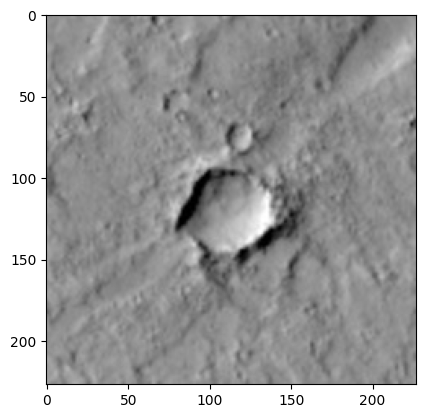

In [17]:
plt.imshow(X_t_A[0], cmap="gray")

In [104]:
def zoom_at(img, zoom=1.0):
    h, w, = [ zoom * i for i in img.shape ]
    cx, cy = w/2, h/2
    img = cv2.resize( img, (0, 0), fx=zoom, fy=zoom)
    img = img[int(round(cy - h/zoom * .5)) : int(round(cy + h/zoom * .5)),
              int(round(cx - w/zoom * .5)) : int(round(cx + w/zoom * .5))]
    return img

# function that rotates an image by 90, 180, and 270 degrees and flips it horizontally and vertically and zooms in on the image and adjusts the brightness randomly
def augment_image_zoom(img):
    img_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE) # rotate the image by 90 degrees clockwise
    img_180 = cv2.rotate(img, cv2.ROTATE_180) # rotate the image by 180 degrees
    img_270 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE) # rotate the image by 270 degrees clockwise
    img_fh = cv2.flip(img, 1) # flip the image horizontally
    img_fv = cv2.flip(img, 0) # flip the image vertically
    img_zoom = zoom_at(img, 1.2) # zoom in on the image
    img_brt = cv2.convertScaleAbs(img, alpha=1.01, beta=np.random.randint(0, 1)) # adjust the brightness randomly
    return img, img_90, img_180, img_270, img_fh, img_fv, img_zoom, img_brt

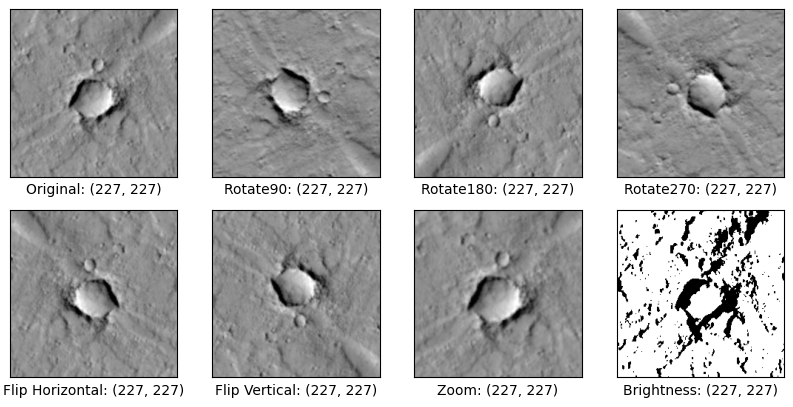

In [109]:
aug_names = ["Original", "Rotate90", "Rotate180", "Rotate270", "Flip Horizontal", "Flip Vertical", "Zoom", "Brightness"]

plt.figure(figsize=(10,10))
counter = 0
for i in augment_image_zoom(X_t_A[0]):
    plt.subplot(4,4,counter+1)
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)
    plt.imshow(i, cmap="gray")
    plt.xlabel(aug_names[counter]+": "+str(i.shape))
    counter += 1
plt.show()

In [129]:
for i in X_t_A[0]:
    

img_brt = X_t_A[0] * 1.1
img_brt

array([[0.71176471, 0.67647059, 0.64509804, ..., 0.68039216, 0.66862745,
        0.66078431],
       [0.70392157, 0.67254902, 0.64901961, ..., 0.68039216, 0.66862745,
        0.66470588],
       [0.68823529, 0.67254902, 0.65686275, ..., 0.68431373, 0.67647059,
        0.67254902],
       ...,
       [0.71960784, 0.73529412, 0.73137255, ..., 0.67254902, 0.68823529,
        0.69215686],
       [0.73137255, 0.72352941, 0.7       , ..., 0.66470588, 0.68431373,
        0.69215686],
       [0.74313725, 0.71960784, 0.67647059, ..., 0.65686275, 0.68431373,
        0.69607843]])

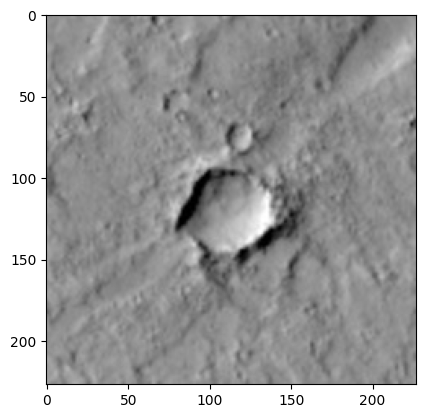

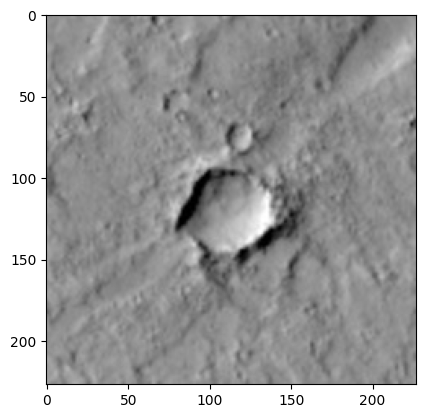

In [127]:
plt.imshow(X_t_A[0], cmap="gray")
plt.show()
adjust_brightness(X_t_A[0])